# Analyzing Monte Carlo Simulations

## Single Run Analysis

   net1     ilout        ildump       vin        vg           vd0      i_in  \
0   0.0  0.000003  2.657073e-08  0.361713  1.143029  1.143029e+00  0.000003   
1   1.0  0.000003  4.657083e-08  0.361700  1.143028  1.497877e-07  0.000003   
2   0.0  0.000003  6.953610e-08  0.361686  1.143028  1.143028e+00  0.000003   
3   1.0  0.000003  8.660279e-08  0.361675  1.143027  1.497840e-07  0.000003   
4   0.0  0.000002  1.108081e-07  0.361661  1.143028  1.143028e+00  0.000003   

           i_vg     vlout    vldump      iout         idump  bit          diff  
0  6.579626e-12  0.237872  0.237173  0.000003  2.659895e-08    0           NaN  
1  6.481992e-11  0.237869  0.237193  0.000002  4.642626e-08    1 -1.944344e-08  
2  6.483124e-11  0.237867  0.237214  0.000002  6.918212e-08    2 -2.232846e-08  
3  1.230966e-10  0.237865  0.237229  0.000002  8.608604e-08    3 -1.659496e-08  
4  6.482301e-11  0.237862  0.237249  0.000002  1.100505e-07    4 -2.353895e-08  


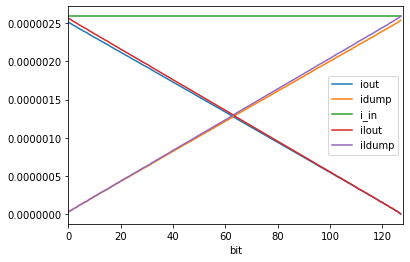

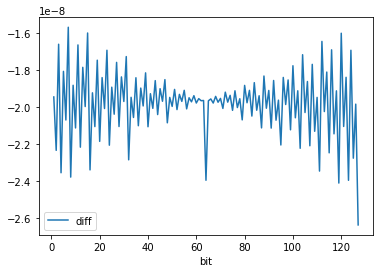

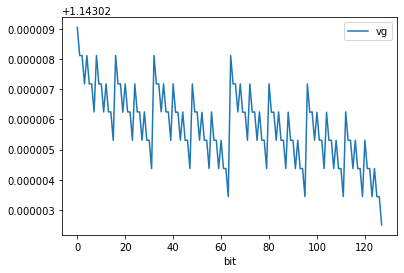

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# load data
data = pd.read_csv("data/mc_dac1.txt", sep=" +", engine='python')
# data.columns = ["net1", "iout", "idump", "i_in", "ilout", "ildump", "vg"]
data.columns = ["net1", "ilout", "ildump", "vin", "vg", "vd0", "i_in", "i_vg", "vlout", "vldump", "iout", "idump"]
# i(VloutI) i(VldumpI) v(Vin) v(Vgate) v(D0) i(VinI) i(VgateI) v(VloutV) v(VldumpV) i(Vout) i(Vdump)
data["bit"] = data.index




#generate curret steps
data["diff"] = data["iout"].diff(1)
# print sample of dataframe
print(data.head())

data.plot("bit", ["iout", "idump", "i_in", "ilout", "ildump"], xlim=(0,128))
plt.show()
data.plot("bit", "diff")
plt.show()

data.plot("bit", "vg")
plt.show()

## Multi-Run Analysis

/home/madvlsi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


   net1     ilout        ildump       vin        vg       vd0      i_in  \
0   0.0  0.000003  2.657073e-08  0.361713  1.143029  1.143029  0.000003   

           i_vg     vlout    vldump      iout         idump  bit  diff  
0  6.579626e-12  0.237872  0.237173  0.000003  2.659895e-08    0   0.0  


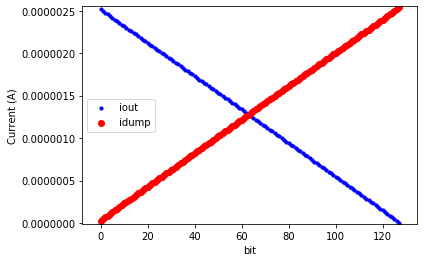

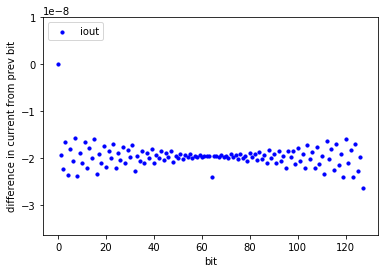

2.49560068e-06


In [17]:
runs = 1
#init data with first run
data = pd.read_csv("data/mc_dac1.txt", sep=" +", engine='python')

#combine multiple runs
for i in range(1, runs):
    data = pd.concat([data, pd.read_csv("data/mc_dac" + str(i + 1)+".txt", sep=" +", engine='python')])
# data.columns = ["net1", "iout", "idump", "i_in", "ilout", "ildump", "bryce"]
data.columns = ["net1", "ilout", "ildump", "vin", "vg", "vd0", "i_in", "i_vg", "vlout", "vldump", "iout", "idump"]
data["bit"] = data.index % 128
data["diff"] = data["iout"].diff(1)

#remove diffs at bits = 0
data["diff"].loc[data["bit"] == 0] = 0
print(data.loc[data["bit"] == 0])

fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.iout, s=10, c='b', label='iout')
ax1.scatter(data.bit, data.idump, c='r', label='idump')
# ax1.scatter(data.bit, data.i_in, c='g', label='i in')
plt.ylim(data.iout.min()-1e-8, data.idump.max()+1e-8)
# plt.xlim(60,80)
plt.legend(loc='center left');
plt.xlabel("bit")
plt.ylabel("Current (A)")
plt.show()

#plotting diffs
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.scatter(data["bit"], data["diff"], s=10, c='b', label='iout')
plt.ylim(data["diff"].min()-1e-8, data["diff"].max()+1e-8)
# plt.xlim(60,80)
plt.legend(loc='upper left');
plt.xlabel("bit")
plt.ylabel("difference in current from prev bit")
plt.show()

#density plot of diff
# data["diff"].plot.density()

print(data["iout"].iloc[1])

### DNL and INL distributions

2.49560068e-06


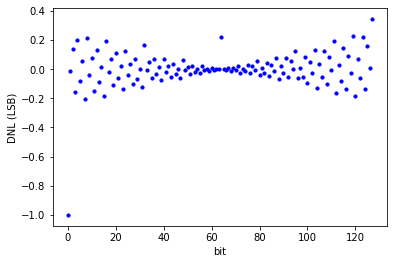

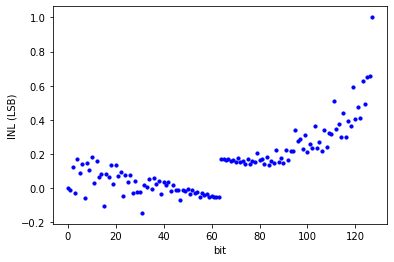

In [18]:
#generate DNL & INL Columns
dnl = []
inl = []
print(data["iout"].iloc[1])
for i in range(128*runs):    
    if i % 128 == 0:
        lsb_current = (data["iout"].iloc[i+127] - data["iout"].iloc[i])/128
        dnl.append(data["diff"].iloc[i] / lsb_current - 1)
        inl.append(0)
    else:
        dnl.append(data["diff"].iloc[i] / lsb_current - 1)
        inl.append(dnl[-1] + inl[-1])
        

        
data["dnl"] = dnl
data["inl"] = inl

# print(dnl)
#DNL
fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.dnl, s=10, c='b', label="dnl")
plt.xlabel("bit")
plt.ylabel("DNL (LSB)")
plt.show()

#INL
fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.inl, s=10, c='b', label="inl")
plt.xlabel("bit")
plt.ylabel("INL (LSB)")
plt.show()

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# load data
data = pd.read_csv("data/iout_mirror.txt", sep=" +", engine='python')
data.columns = ["net1", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
data["bit"] = data.index


data.plot("bit", ["ibias", "iout", "i_in"])

FileNotFoundError: [Errno 2] No such file or directory: 'data/iout_mirror.txt'

In [20]:

# load data
data2 = pd.read_csv("data/iout2_mirror.txt", sep=" +", engine='python')
data2.columns = ["net1", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
data2["bit"] = data2.index


data2.plot("bit", ["ibias", "iout", "i_in"])

FileNotFoundError: [Errno 2] No such file or directory: 'data/iout2_mirror.txt'

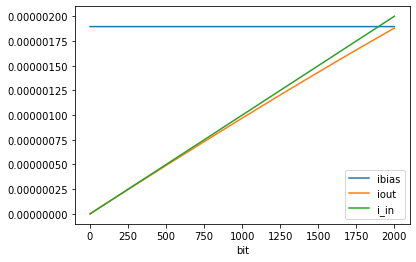

In [57]:

# load data
data3 = pd.read_csv("data/iout3_mirror.txt", sep=" +", engine='python')
data3.columns = ["net1", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
data3["bit"] = data3.index


data3.plot("bit", ["ibias", "iout", "i_in"])

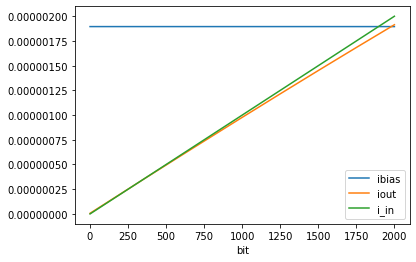

In [66]:

# load data
data4 = pd.read_csv("data/iout4_mirror.txt", sep=" +", engine='python')
data4.columns = ["net1", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
data4["bit"] = data4.index


data4.plot("bit", ["ibias", "iout", "i_in"])

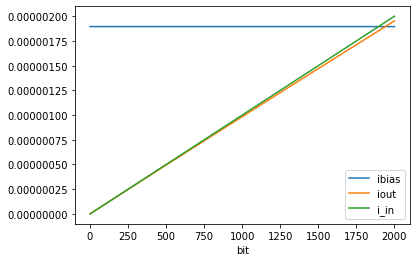

In [67]:

# load data
data5 = pd.read_csv("data/iout5_mirror.txt", sep=" +", engine='python')
data5.columns = ["net1", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
data5["bit"] = data4.index


data5.plot("bit", ["ibias", "iout", "i_in"])

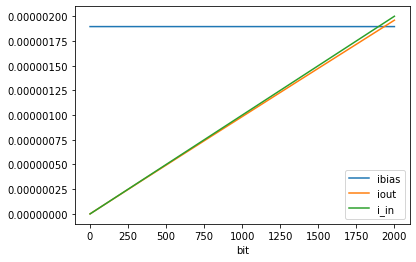

In [69]:
# load data
data6 = pd.read_csv("data/iout6_mirror.txt", sep=" +", engine='python')
data6.columns = ["net1", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
data6["bit"] = data4.index


data6.plot("bit", ["ibias", "iout", "i_in"])

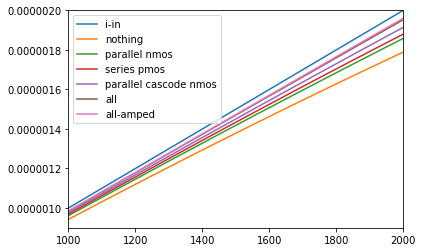

In [70]:
plt.plot(data.bit, data.i_in)
plt.plot(data.bit, data.iout)
plt.plot(data2.bit, data2.iout)
plt.plot(data3.bit, data3.iout)
plt.plot(data4.bit, data4.iout)
plt.plot(data5.bit, data5.iout)
plt.plot(data6.bit, data6.iout)
plt.legend(["i-in","nothing", "parallel nmos", "series pmos", "parallel cascode nmos", "all", "all-amped"])
plt.xlim(1000, 2000)
plt.ylim(.9e-6, 2e-6)
plt.show()

   vsweep      i_in          iout     ibias           iv1           iv2  \
0   0.000  0.000002 -9.414822e-07  0.000002  9.414822e-07  0.000000e+00   
1   0.001  0.000002 -8.835687e-07  0.000002  9.414768e-07  5.790811e-08   
2   0.002  0.000002 -8.264870e-07  0.000002  9.414714e-07  1.149844e-07   
3   0.003  0.000002 -7.702340e-07  0.000002  9.414661e-07  1.712321e-07   
4   0.004  0.000002 -7.148064e-07  0.000002  9.414607e-07  2.266543e-07   

        vbp       vcn  
0  0.690959  0.716436  
1  0.690959  0.716436  
2  0.690959  0.716436  
3  0.690959  0.716436  
4  0.690959  0.716436  
1644 204
2.02031902e-06
1.82632409e-06
percent error:  6.6681895312201185


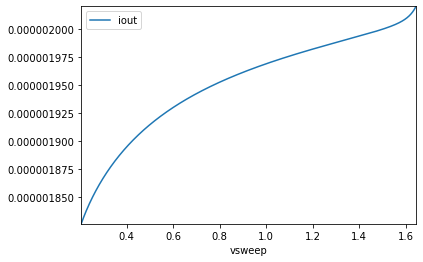

In [264]:
# load data
data = pd.read_csv("data/trash_mirror.txt", sep=" +", engine='python')
# data.columns = ["vsweep", "i_in", "iout", "idump", "ilout", "ildump", "vbp", "vcn"]
data.columns = ["vsweep", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
print(data.head())
# print(data.ibias.iloc[0])

mid = 924
ulim = int(.4*1800 + mid)
llim = int(mid - .4*1800)
print(ulim, llim)

data.plot("vsweep", "iout", xlim=(data.vsweep.iloc[llim], data.vsweep.iloc[ulim]), ylim=(data.iout.iloc[llim], data.iout.iloc[ulim]))

print(data.iout.iloc[ulim])
print(data.iout.iloc[llim])

error = ((data.iout.iloc[ulim] - data.iout.iloc[llim]) / data.iout.iloc[ulim]) / (data.vsweep.iloc[ulim]-data.vsweep.iloc[llim])
print("percent error: ", error*100)

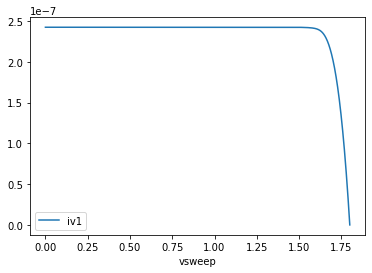

In [232]:
data.plot("vsweep", "iv1")

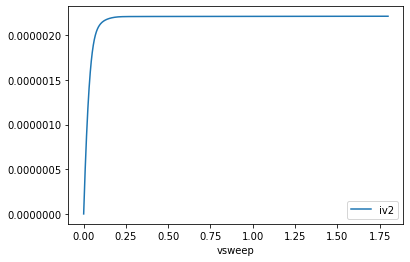

In [233]:
data.plot("vsweep", "iv2")